In [1]:
# generate toy data
import numpy as np
import time
import warnings
import pandas as pd

rng = np.random.RandomState(1)

num_samples = 20
#num_samples = 10000

data_x = rng.uniform(low=-4, high=4, size=(num_samples,))
data_y = data_x**3 + rng.normal(loc=0, scale=9, size=(num_samples,))

linspace = np.linspace(-6, 6, num=500)

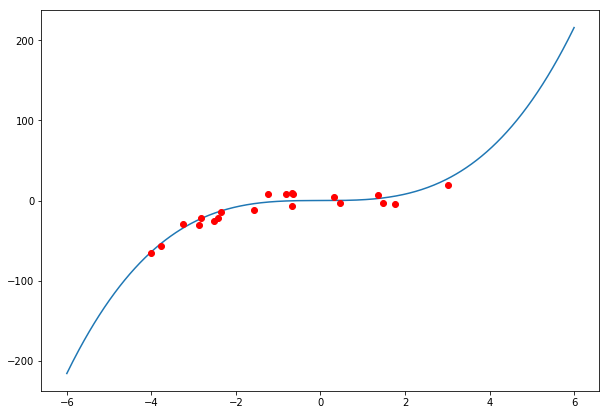

In [2]:
# plot toy data
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
plt.plot(linspace, linspace ** 3)
plt.plot(data_x, data_y, 'ro')
plt.show()

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from tqdm import trange
from model import ToyNN
import torch.distributions as dist

def seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    np.random.seed(seed)
    random.seed(seed)

In [4]:
seed(42)

In [5]:
model = ToyNN()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, eps=1e-5)

crit = lambda x, y: torch.sum(-1 * dist.Normal(0., 9.).log_prob(x - y))

/Users/nickpawlowski/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


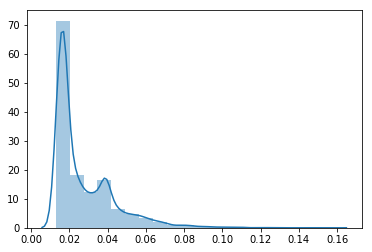

0.027194269001483917 - 0.015993280336260796


In [6]:
samples_before = model.sample(10000).detach().numpy()
sns.distplot(samples_before[:, 0], bins=20)
plt.show()
print('{} - {}'.format(samples_before[:, 0].mean(), samples_before[:, 0].std()))

In [7]:
cols = ['x', 'y', 'mode', 'mc']


batch_x = torch.from_numpy(data_x.astype(np.float32).reshape(20, 1))
batch_y = torch.from_numpy(data_y.astype(np.float32).reshape(20, 1))

with trange(200) as pbar:
    for i in pbar:
        optimizer.zero_grad()
        cur_anneal = np.clip(10. / (i + 1) - 1., 0., 1.)
        preds = model(batch_x)
        mse = crit(preds, batch_y)
        kl = model.kl()

        loss = mse + cur_anneal * kl

        loss.backward()
        optimizer.step()
        
        pbar.set_postfix(loss=loss.detach().numpy(), mse=mse.detach().numpy(), kl=kl.detach().numpy())

100%|██████████| 200/200 [00:03<00:00, 59.59it/s, kl=452.24854, loss=70.28275, mse=70.28275]    


/Users/nickpawlowski/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


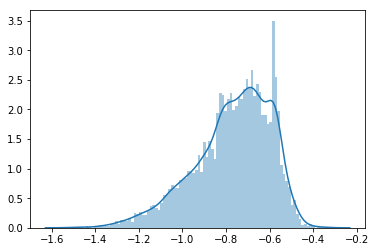

-0.7705367207527161 - 0.2043093889951706


In [8]:
samples_after = model.sample(10000).detach().numpy()
w_idx = 20
sns.distplot(samples_after[:, w_idx], bins=100)
plt.show()
print('{} - {}'.format(samples_after[:, w_idx].mean(), samples_after[:, 0].std()))

In [9]:
mcsteps = 100

prediction_df = pd.DataFrame(columns=cols)
all_preds = np.zeros(len(linspace))
batch_x = torch.from_numpy(linspace[:, np.newaxis].astype(np.float32))
for mc in range(mcsteps):
    with torch.no_grad():
        predictions = model(batch_x)[:, 0]
    all_preds += predictions.numpy() / mcsteps
    new_df = pd.DataFrame(columns=cols, data=list(zip(
            linspace, predictions.numpy(), ['implicit']*len(linspace), [mc]*len(linspace))))

    prediction_df = pd.concat([prediction_df, new_df])

In [10]:
print(np.sqrt(np.mean((all_preds - linspace ** 3)**2)))

52.733687376607655


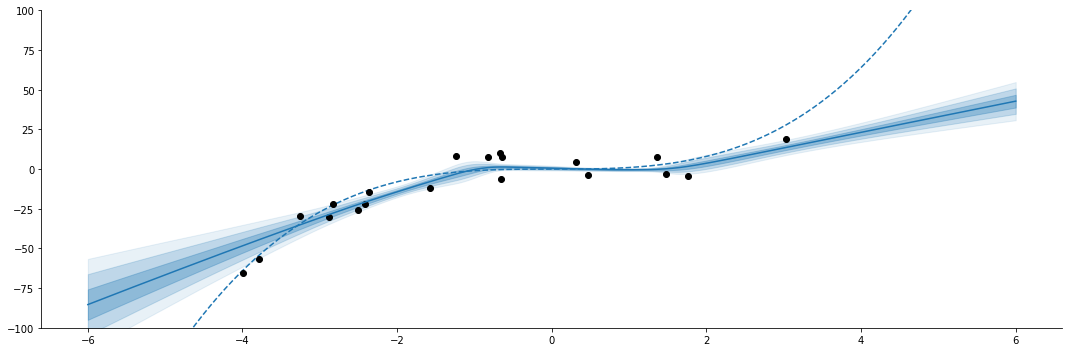

In [11]:
plt.figure(figsize=(15, 5))

plt.plot(linspace, linspace ** 3, '--', label='Real function')
plt.plot(data_x, data_y, 'o', color='black', label='Samples')

colour = sns.color_palette(n_colors=9)[0]

groups = prediction_df.groupby(['x'])
mean_pred = groups.mean().values[:, 0]
std_pred = groups.std().values[:, 0]
plt.plot(linspace, mean_pred, color=colour)

plt.fill_between(linspace,
                 mean_pred + 1 * std_pred,
                 mean_pred - 1 * std_pred,
                 color=colour, alpha=0.3)
plt.fill_between(linspace,
                 mean_pred + 2 * std_pred,
                 mean_pred - 2 * std_pred,
                 color=colour, alpha=0.2)
plt.fill_between(linspace,
                 mean_pred + 3 * std_pred,
                 mean_pred - 3 * std_pred,
                 color=colour, alpha=0.1)

plt.ylim(-100, 100)
sns.despine()
plt.tight_layout()
plt.show()